# Import Statements

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import joblib
import optuna
import sklearn 

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Load Data

In [2]:
# load data
train = pd.read_csv('../input/forest-cover-type-prediction/train.csv')
# view data
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [3]:
# remove ID column from set
train = train.iloc[:, 1:]
train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


# Add Features from Feature Engineering

In [4]:
# add new features from feature engineering
train['Elev_to_Horizontal_Hyd'] = train.Elevation - 0.2 * train.Horizontal_Distance_To_Hydrology 
train['Elev_to_Horizontal_Road'] = train.Elevation - 0.05 * train.Horizontal_Distance_To_Roadways  
train['Elev_to_Verticle_Hyd'] = train.Elevation - train.Vertical_Distance_To_Hydrology 
train['Mean_Horizontal_Dist'] = (train.Horizontal_Distance_To_Fire_Points + train.Horizontal_Distance_To_Hydrology + 
                                 train.Horizontal_Distance_To_Roadways)/3 
train['Mean_Fire_Hydro'] = (train.Horizontal_Distance_To_Fire_Points + train.Horizontal_Distance_To_Hydrology)/2

# EDA

In [5]:
# check for missing values
train.isnull().values.any()

False

In [6]:
# summary
train.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,Elev_to_Horizontal_Hyd,Elev_to_Horizontal_Road,Elev_to_Verticle_Hyd,Mean_Horizontal_Dist,Mean_Fire_Hydro
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,...,0.002249,0.048148,0.043452,0.030357,4.000000,2703.883413,2663.621392,2698.246032,1150.788735,869.171495
std,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,...,0.047368,0.214086,0.203880,0.171574,2.000066,402.163115,383.169169,414.680029,716.025159,576.061501
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1839.000000,1858.500000,1842.000000,38.333333,15.000000
25%,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,2338.750000,2336.250000,2323.000000,652.583333,451.500000
50%,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,...,0.000000,0.000000,0.000000,0.000000,4.000000,2711.500000,2676.600000,2696.000000,920.166667,731.000000
75%,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,1988.250000,...,0.000000,0.000000,0.000000,0.000000,6.000000,3049.250000,2974.750000,3068.000000,1524.750000,1151.000000
max,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,6993.000000,...,1.000000,1.000000,1.000000,1.000000,7.000000,3670.800000,3626.800000,3776.000000,4361.000000,3583.500000


In [7]:
# dimensions of data set 
print(train.shape) # 60 columns
# column names
print(train.columns)

(15120, 60)
Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 

# Preprocessing

In [8]:
# move target to first column
first_column = train.pop('Cover_Type')
  
# insert column using insert(position,column_name,first_column) function
train.insert(0, 'Cover_Type', first_column)
  
# view
train.head()

,Cover_Type,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Elev_to_Horizontal_Hyd,Elev_to_Horizontal_Road,Elev_to_Verticle_Hyd,Mean_Horizontal_Dist,Mean_Fire_Hydro
0,5,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,2544.4,2570.50,2596,2349.000000,3268.5
1,5,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,2547.6,2570.50,2596,2275.666667,3218.5
2,2,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,2750.4,2645.00,2739,3189.666667,3194.5
3,2,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,2736.6,2630.50,2667,3181.000000,3226.5
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,2564.4,2575.45,2596,2238.666667,3162.5


In [9]:
# create cat, num, and y
X_cat = train.iloc[:, 11:55].values
B = train.iloc[:, 55:60]
A = train.iloc[:, 1:11]
X_num = pd.concat([A, B], axis = 1).values
y = train.iloc[:, 0].values

In [10]:
# scale/standardizing numerical columns
# scaler object
scaler = StandardScaler()
# fit to training data
scaler.fit(X_num)
# scale num columns
X_num = scaler.transform(X_num)

# shape
print(f'Categorical Shape: {X_cat.shape}')
print(f'Numerical Shape: {X_num.shape}')
print(f'Label Shape: {y.shape}')

Categorical Shape: (15120, 44)
Numerical Shape: (15120, 15)
Label Shape: (15120,)


In [11]:
# combine num and cat
X = np.hstack((X_num, X_cat))
print(X.shape)

(15120, 59)


# PCA

Text(0.5, 1.0, 'PCA Number of Components for Cumulative Variance')

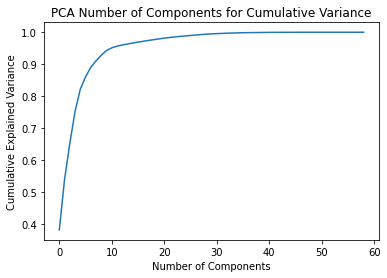

In [12]:
# PCA to find the number of components
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Number of Components for Cumulative Variance')

In [13]:
# PCA
pca = PCA(n_components = 10)
pca.fit(X)

PCA(n_components=10)

In [14]:
# print components
print(pca.components_)

# print variances
print(pca.explained_variance_)

[[ 3.67381366e-01  6.48011123e-03 -1.72557404e-01  1.69532507e-01
   3.58311028e-02  2.89989148e-01  3.52355142e-02  1.32550715e-01
   7.03404149e-02  2.75029685e-01  3.63843075e-01  3.50326828e-01
   3.64746062e-01  3.36293883e-01  2.93484097e-01  6.96012643e-02
   1.21449009e-02  5.71420514e-02 -1.38888217e-01 -1.25546806e-02
  -9.65928325e-03 -2.94122676e-02 -9.96684080e-03 -5.68364626e-03
  -1.37846004e-02  0.00000000e+00  4.54505940e-05 -1.10209039e-04
  -5.15725586e-02 -1.90922332e-03  4.74502465e-03  5.57192688e-04
  -5.40853308e-03  0.00000000e+00 -1.24595498e-03 -1.20495364e-02
   9.81126059e-04  8.14759410e-04  1.56442667e-03  2.28584315e-04
   7.82317757e-03  1.41535920e-02  4.11935188e-03  2.71481491e-05
   9.13818155e-04  4.95423787e-04 -2.30240423e-05  2.65219679e-02
   9.16380043e-04  4.21596687e-03  1.22205015e-02  7.86182307e-03
   3.82776229e-04  2.93701152e-03  3.67005730e-04  1.16873593e-03
   2.45379116e-02  1.73488510e-02  1.84323512e-02]
 [ 4.77286397e-02 -4.9257

# Logistic Regression

Logistic Regression did not yield high accuracy with GridSearchCV or Optuna hyperparameter tuning. 

In [15]:
# best model 

lr_model = LogisticRegression(random_state = 1, 
                              penalty = 'none', 
                              max_iter = 500, 
                              solver = 'saga')
lr_model.fit(X, y)
print(lr_model.score(X, y))

0.7126322751322751


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


# Decision Tree

In [16]:
%%time

# optuna hyperparameter tuning
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32)
    dt_clf = DecisionTreeClassifier(random_state = 1, max_depth = max_depth, min_samples_leaf = min_samples_leaf)
    return sklearn.model_selection.cross_val_score(dt_clf, X, y, n_jobs = -1, cv = 10).mean()
    
dt_study = optuna.create_study(direction='maximize')
dt_study.optimize(objective, n_trials=100)
dt = dt_study.best_trial
print('Accuracy: {}'.format(dt.value))
print("Best hyperparameters: {}".format(dt.params))

[I 2021-11-28 18:19:16,580] A new study created in memory with name: no-name-c154bab4-2b2f-4b2f-b254-c6008b742b79
[I 2021-11-28 18:19:20,844] Trial 0 finished with value: 0.6993386243386243 and parameters: {'max_depth': 15, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.6993386243386243.
[I 2021-11-28 18:19:22,394] Trial 1 finished with value: 0.6651455026455027 and parameters: {'max_depth': 40, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.6993386243386243.
[I 2021-11-28 18:19:23,553] Trial 2 finished with value: 0.6602513227513228 and parameters: {'max_depth': 9, 'min_samples_leaf': 31}. Best is trial 0 with value: 0.6993386243386243.
[I 2021-11-28 18:19:25,078] Trial 3 finished with value: 0.6922619047619047 and parameters: {'max_depth': 44, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.6993386243386243.
[I 2021-11-28 18:19:26,474] Trial 4 finished with value: 0.6613756613756614 and parameters: {'max_depth': 10, 'min_samples_leaf': 32}. Best is trial 0 with 

Accuracy: 0.714484126984127
Best hyperparameters: {'max_depth': 33, 'min_samples_leaf': 1}
CPU times: user 5.77 s, sys: 709 ms, total: 6.48 s
Wall time: 3min 3s


#### Best Params

- Accuracy: 0.7187169312169313
- Best hyperparameters: {'max_depth': 19, 'min_samples_leaf': 1}

In [17]:
# dt best model
dt_model = DecisionTreeClassifier(random_state = 1, 
                                  max_depth = dt_study.best_trial.params['max_depth'], 
                                  min_samples_leaf = dt_study.best_trial.params['min_samples_leaf'])
dt_model.fit(X, y)

DecisionTreeClassifier(max_depth=33, random_state=1)

# Random Forest

In [18]:
%%time

# optuna hyperparameter tuning
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 150)
    max_depth = trial.suggest_int('max_depth', 20, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    rf_clf = RandomForestClassifier(random_state = 1, n_estimators = n_estimators, max_depth = max_depth, min_samples_leaf = min_samples_leaf)
    return sklearn.model_selection.cross_val_score(rf_clf, X, y, n_jobs = -1, cv = 10).mean()
    
rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(objective, n_trials=20)
rf = rf_study.best_trial
print('Accuracy: {}'.format(rf.value))
print("Best hyperparameters: {}".format(rf.params))

[I 2021-11-28 18:22:20,817] A new study created in memory with name: no-name-c454d7f4-9dca-4ba1-bec6-15f2d07fbe36
[I 2021-11-28 18:22:41,791] Trial 0 finished with value: 0.7430555555555556 and parameters: {'n_estimators': 148, 'max_depth': 41, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.7430555555555556.
[I 2021-11-28 18:22:56,757] Trial 1 finished with value: 0.7444444444444445 and parameters: {'n_estimators': 107, 'max_depth': 21, 'min_samples_leaf': 13}. Best is trial 1 with value: 0.7444444444444445.
[I 2021-11-28 18:23:16,379] Trial 2 finished with value: 0.7482142857142857 and parameters: {'n_estimators': 135, 'max_depth': 21, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.7482142857142857.
[I 2021-11-28 18:23:38,925] Trial 3 finished with value: 0.756084656084656 and parameters: {'n_estimators': 146, 'max_depth': 34, 'min_samples_leaf': 7}. Best is trial 3 with value: 0.756084656084656.
[I 2021-11-28 18:23:52,320] Trial 4 finished with value: 0.73260582010582

Accuracy: 0.8003968253968254
Best hyperparameters: {'n_estimators': 130, 'max_depth': 49, 'min_samples_leaf': 1}
CPU times: user 1.29 s, sys: 171 ms, total: 1.47 s
Wall time: 6min 49s


#### Best Params

- Accuracy: 0.8003968253968254
- Best hyperparameters: {'n_estimators': 130, 'max_depth': 50, 'min_samples_leaf': 1}


In [19]:
# best model
rf_model = RandomForestClassifier(random_state = 1, 
                                  n_estimators = rf_study.best_trial.params['n_estimators'], 
                                  max_depth = rf_study.best_trial.params['max_depth'], 
                                  min_samples_leaf = rf_study.best_trial.params['min_samples_leaf'])

rf_model.fit(X, y)

RandomForestClassifier(max_depth=49, n_estimators=130, random_state=1)

# Extra Tree Classifier

In [20]:
%%time

# optuna hyperparameter tuning
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 30, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    tree_clf = ExtraTreesClassifier(random_state = 0, n_estimators = 200, max_depth = max_depth, min_samples_leaf = min_samples_leaf)
    return sklearn.model_selection.cross_val_score(tree_clf, X, y, n_jobs = -1, cv = 10).mean()
    
tree_study = optuna.create_study(direction='maximize')
tree_study.optimize(objective, n_trials=20)
tree = tree_study.best_trial
print('Accuracy: {}'.format(tree.value))
print("Best hyperparameters: {}".format(tree.params))

[I 2021-11-28 18:29:14,663] A new study created in memory with name: no-name-fa83311a-76aa-4bce-ae8d-b125cb48ddac
[I 2021-11-28 18:29:26,965] Trial 0 finished with value: 0.7062169312169313 and parameters: {'max_depth': 33, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.7062169312169313.
[I 2021-11-28 18:29:42,421] Trial 1 finished with value: 0.7433201058201058 and parameters: {'max_depth': 35, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.7433201058201058.
[I 2021-11-28 18:29:55,334] Trial 2 finished with value: 0.7062169312169313 and parameters: {'max_depth': 36, 'min_samples_leaf': 17}. Best is trial 1 with value: 0.7433201058201058.
[I 2021-11-28 18:30:08,649] Trial 3 finished with value: 0.7083994708994709 and parameters: {'max_depth': 43, 'min_samples_leaf': 15}. Best is trial 1 with value: 0.7433201058201058.
[I 2021-11-28 18:30:20,942] Trial 4 finished with value: 0.7009920634920636 and parameters: {'max_depth': 38, 'min_samples_leaf': 18}. Best is trial 1 with

Accuracy: 0.8089285714285713
Best hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1}
CPU times: user 1.21 s, sys: 178 ms, total: 1.39 s
Wall time: 5min 13s


#### Best Params

- Accuracy: 0.809457671957672
- Best hyperparameters: {'max_depth': 33, 'min_samples_leaf': 1}

In [21]:
# best model
tree_model = ExtraTreesClassifier(random_state = 1, 
                                  n_estimators = 200, 
                                  max_depth = tree_study.best_trial.params['max_depth'], 
                                  min_samples_leaf = tree_study.best_trial.params['min_samples_leaf'])

tree_model.fit(X, y)

ExtraTreesClassifier(max_depth=30, n_estimators=200, random_state=1)

# Gradient Boosting Classifier

In [22]:
%%time

# optuna hyperparameter tuning
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 10, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 15, 20)
    gradb_clf = GradientBoostingClassifier(random_state = 0, max_depth = max_depth, min_samples_leaf = min_samples_leaf)
    return sklearn.model_selection.cross_val_score(gradb_clf, X, y, n_jobs = -1, cv = 10).mean()
    
gradb_study = optuna.create_study(direction='maximize')
gradb_study.optimize(objective, n_trials = 5)
gradb = gradb_study.best_trial
print('Accuracy: {}'.format(gradb.value))
print("Best hyperparameters: {}".format(gradb.params))

[I 2021-11-28 18:34:31,380] A new study created in memory with name: no-name-5dfeda37-0d19-48fa-a2a0-37ed9d6d49ac
[I 2021-11-28 18:54:23,483] Trial 0 finished with value: 0.80244708994709 and parameters: {'max_depth': 15, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.80244708994709.
[I 2021-11-28 19:13:22,801] Trial 1 finished with value: 0.8003968253968254 and parameters: {'max_depth': 14, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.80244708994709.
[I 2021-11-28 19:38:10,444] Trial 2 finished with value: 0.8019179894179894 and parameters: {'max_depth': 20, 'min_samples_leaf': 16}. Best is trial 0 with value: 0.80244708994709.
[I 2021-11-28 19:58:11,967] Trial 3 finished with value: 0.7990079365079366 and parameters: {'max_depth': 15, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.80244708994709.
[I 2021-11-28 20:13:41,909] Trial 4 finished with value: 0.7970899470899471 and parameters: {'max_depth': 11, 'min_samples_leaf': 20}. Best is trial 0 with value: 0

Accuracy: 0.80244708994709
Best hyperparameters: {'max_depth': 15, 'min_samples_leaf': 20}
CPU times: user 664 ms, sys: 530 ms, total: 1.19 s
Wall time: 1h 39min 10s


#### Best Params

- Accuracy: 0.8049603174603176
- Best hyperparameters: {'max_depth': 19, 'min_samples_leaf': 16}

In [23]:
%%time
# best model
gradb_model = GradientBoostingClassifier(random_state = 0,
                                         max_depth = 19, 
                                         min_samples_leaf = 16)

gradb_model.fit(X, y)

CPU times: user 3min 30s, sys: 108 ms, total: 3min 30s
Wall time: 3min 31s


GradientBoostingClassifier(max_depth=19, min_samples_leaf=16, random_state=0)

In [24]:
%%time
# best model
gradb_model = GradientBoostingClassifier(random_state = 0,
                                         max_depth = gradb_study.best_trial.params['max_depth'], 
                                         min_samples_leaf = gradb_study.best_trial.params['min_samples_leaf'])

gradb_model.fit(X, y)

CPU times: user 2min 53s, sys: 142 ms, total: 2min 53s
Wall time: 2min 54s


GradientBoostingClassifier(max_depth=15, min_samples_leaf=20, random_state=0)

# Extreme Gradient Boosting

In [25]:
%%time

# optuna hyperparameter tuning
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 10, 20)
    xgb_clf = XGBClassifier(random_state = 0, max_depth = max_depth, tree_method = 'gpu_hist')
    return sklearn.model_selection.cross_val_score(xgb_clf, X, y, n_jobs = -1, cv = 10).mean()
    
xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(objective, n_trials = 5)
xgb = xgb_study.best_trial
print('Accuracy: {}'.format(xgb.value))
print("Best hyperparameters: {}".format(xgb.params))

[I 2021-11-28 20:20:09,165] A new study created in memory with name: no-name-7eebfcf6-416f-421a-aee6-06c6f184ce0a
[I 2021-11-28 20:22:01,194] Trial 0 finished with value: 0.799074074074074 and parameters: {'max_depth': 16}. Best is trial 0 with value: 0.799074074074074.
[I 2021-11-28 20:23:49,310] Trial 1 finished with value: 0.799074074074074 and parameters: {'max_depth': 16}. Best is trial 0 with value: 0.799074074074074.
[I 2021-11-28 20:25:36,499] Trial 2 finished with value: 0.799074074074074 and parameters: {'max_depth': 16}. Best is trial 0 with value: 0.799074074074074.
[I 2021-11-28 20:27:24,433] Trial 3 finished with value: 0.799074074074074 and parameters: {'max_depth': 16}. Best is trial 0 with value: 0.799074074074074.
[I 2021-11-28 20:29:25,946] Trial 4 finished with value: 0.798148148148148 and parameters: {'max_depth': 20}. Best is trial 0 with value: 0.799074074074074.


Accuracy: 0.799074074074074
Best hyperparameters: {'max_depth': 16}
CPU times: user 358 ms, sys: 107 ms, total: 465 ms
Wall time: 9min 16s


#### Best Params

- Accuracy: 0.7998015873015873
- Best hyperparameters: {'max_depth': 14}

In [26]:
%%time
# best model
xgb_model = XGBClassifier(random_state = 0,
                           max_depth = 14,
                           tree_method = 'gpu_hist')

xgb_model.fit(X, y)
xgb_model.score(X, y)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:29:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 7.59 s, sys: 239 ms, total: 7.83 s
Wall time: 7.47 s


1.0

# AdaBoost 

In [27]:
%%time

# optuna hyperparameter tuning
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 1, 15)
    adab_clf = AdaBoostClassifier(random_state = 0, n_estimators = n_estimators)
    return sklearn.model_selection.cross_val_score(adab_clf, X, y, n_jobs = -1, cv = 10).mean()
    
adab_study = optuna.create_study(direction='maximize')
adab_study.optimize(objective, n_trials = 10)
adab = adab_study.best_trial
print('Accuracy: {}'.format(adab.value))
print("Best hyperparameters: {}".format(adab.params))

[I 2021-11-28 20:29:34,219] A new study created in memory with name: no-name-4552a77c-b71d-4776-9b05-354ec63a5b6b
[I 2021-11-28 20:29:35,389] Trial 0 finished with value: 0.4352513227513227 and parameters: {'n_estimators': 5}. Best is trial 0 with value: 0.4352513227513227.
[I 2021-11-28 20:29:38,250] Trial 1 finished with value: 0.4474206349206349 and parameters: {'n_estimators': 12}. Best is trial 1 with value: 0.4474206349206349.
[I 2021-11-28 20:29:38,799] Trial 2 finished with value: 0.38921957671957674 and parameters: {'n_estimators': 2}. Best is trial 1 with value: 0.4474206349206349.
[I 2021-11-28 20:29:40,145] Trial 3 finished with value: 0.45436507936507936 and parameters: {'n_estimators': 6}. Best is trial 3 with value: 0.45436507936507936.
[I 2021-11-28 20:29:42,928] Trial 4 finished with value: 0.3843915343915344 and parameters: {'n_estimators': 13}. Best is trial 3 with value: 0.45436507936507936.
[I 2021-11-28 20:29:45,080] Trial 5 finished with value: 0.4491402116402116

Accuracy: 0.45436507936507936
Best hyperparameters: {'n_estimators': 6}
CPU times: user 470 ms, sys: 73.1 ms, total: 543 ms
Wall time: 18.1 s


#### Best Params

- Accuracy: 0.45436507936507936
- Best hyperparameters: {'n_estimators': 6}

In [28]:
# best model
adab_model = AdaBoostClassifier(random_state = 0, 
                                n_estimators = adab_study.best_trial.params['n_estimators'])

adab_model.fit(X, y)

AdaBoostClassifier(n_estimators=6, random_state=0)

# MLP Classifier

In [29]:
# 

# LightGBM

In [30]:
%%time

# optuna hyperparameter tuning
def objective(trial):
    num_leaves = trial.suggest_int('num_leaves', 10, 20)
    max_depth = trial.suggest_int('max_depth', 10, 20)
    lgbm_clf = LGBMClassifier(random_state = 0, )
    return sklearn.model_selection.cross_val_score(lgbm_clf, X, y, n_jobs = -1, cv = 10).mean()
    
lgbm_study = optuna.create_study(direction='maximize')
lgbm_study.optimize(objective, n_trials = 10)
lgbm = lgbm_study.best_trial
print('Accuracy: {}'.format(lgbm.value))
print("Best hyperparameters: {}".format(lgbm.params))

[I 2021-11-28 20:29:53,501] A new study created in memory with name: no-name-39dcccb8-5a23-4515-bccf-17e44446ceca
[I 2021-11-28 20:30:12,121] Trial 0 finished with value: 0.7878306878306878 and parameters: {'num_leaves': 20, 'max_depth': 20}. Best is trial 0 with value: 0.7878306878306878.
[I 2021-11-28 20:30:28,973] Trial 1 finished with value: 0.7878306878306878 and parameters: {'num_leaves': 18, 'max_depth': 14}. Best is trial 0 with value: 0.7878306878306878.
[I 2021-11-28 20:30:46,797] Trial 2 finished with value: 0.7878306878306878 and parameters: {'num_leaves': 10, 'max_depth': 15}. Best is trial 0 with value: 0.7878306878306878.
[I 2021-11-28 20:31:04,690] Trial 3 finished with value: 0.7878306878306878 and parameters: {'num_leaves': 12, 'max_depth': 12}. Best is trial 0 with value: 0.7878306878306878.
[I 2021-11-28 20:31:22,093] Trial 4 finished with value: 0.7878306878306878 and parameters: {'num_leaves': 13, 'max_depth': 10}. Best is trial 0 with value: 0.7878306878306878.
[

Accuracy: 0.7878306878306878
Best hyperparameters: {'num_leaves': 20, 'max_depth': 20}
CPU times: user 624 ms, sys: 98.5 ms, total: 723 ms
Wall time: 2min 56s


#### Best Params

- Accuracy: 0.7878306878306878
- Best hyperparameters: {'num_leaves': 10, 'max_depth': 16}

In [31]:
%%time
# best model
lgbm_model = LGBMClassifier(random_state = 0,
                            max_depth = lgbm_study.best_trial.params['max_depth'],
                            num_leaves = lgbm_study.best_trial.params['num_leaves'])

lgbm_model.fit(X, y)

CPU times: user 3.15 s, sys: 62 ms, total: 3.21 s
Wall time: 1.63 s


LGBMClassifier(max_depth=20, num_leaves=20, random_state=0)

# Model Selection

In [32]:
%%time 
# create ensemble classifier 
ensemble_model = VotingClassifier(
    estimators = [('tree', tree_model), 
                  ('rf', rf_model), 
                  ('gradb', gradb_model), 
                  ('xgb', xgb_model)],
    voting = 'hard'
)

# fit
ensemble_model.fit(X, y)

# print training accuracy
print('Logistic Regression Accuracy', lr_model.score(X, y))
print('Decision Tree Accuracy', dt_model.score(X, y))
print('Random Forest Accuracy', rf_model.score(X, y))
print('Extra Trees Accuracy', tree_model.score(X, y))
print('Gradient Boosting Accuracy', gradb_model.score(X, y))
print('Extra Gradient Boosting Accuracy', xgb_model.score(X, y))
print('AdaBoost Accuracy', adab_model.score(X, y))
print('LightGBM Accuracy', lgbm_model.score(X, y))
print('Ensemble Accuracy:', ensemble_model.score(X, y))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Logistic Regression Accuracy 0.7126322751322751
Decision Tree Accuracy 1.0
Random Forest Accuracy 1.0
Extra Trees Accuracy 1.0
Gradient Boosting Accuracy 1.0
Extra Gradient Boosting Accuracy 1.0
AdaBoost Accuracy 0.426521164021164
LightGBM Accuracy 0.9570767195767196
Ensemble Accuracy: 1.0
CPU times: user 3min 11s, sys: 415 ms, total: 3min 12s
Wall time: 3min 11s


- Logistic Regression Accuracy 0.7126322751322751
- Decision Tree Accuracy 0.9808201058201058
- Random Forest Accuracy 0.9999338624338624
- Extra Trees Accuracy 1.0
- Gradient Boosting Accuracy 1.0
- Extra Gradient Boosting Accuracy 1.0
- AdaBoost Accuracy 0.426521164021164
- LightGBM Accuracy 0.8923941798941799
- Ensemble Accuracy: 1.0

# Save Preprocessor and Models

In [33]:
# save scaler
joblib.dump(scaler, 'forest_cover_scaler2.joblib')

['forest_cover_scaler2.joblib']

In [34]:
joblib.dump(rf_model, 'rf_model_3.joblib')
joblib.dump(tree_model, 'tree_model_3.joblib')
joblib.dump(gradb_model, 'gradb_model_3.joblib')
joblib.dump(xgb_model, 'xgb_model_3.joblib')
joblib.dump(adab_model, 'adab_model_3.joblib')
joblib.dump(lgbm_model, 'lgbm_model_3.joblib')
joblib.dump(ensemble_model, 'ensemble_model_3.joblib')
print('Model written to file.')

Model written to file.
